Deep Learning How to Fit a ball-stick Model to HCP diffusion MRI data

This is an adaptation of the original notebook describing the IVIM fitting approach proposed in "Deep Learning How to Fit an Intravoxel Incoherent Motion Model to Diffusion-Weighted MRI" by Barbieri et al., 2019. A preprint of the paper can be found at: https://arxiv.org/abs/1903.00095

Note that I wrote this code quickly without much care so there's probably some bugs!

Authors: Paddy Slator, Jason Lim, UCL.
p.slator@ucl.ac.uk


In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
# import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

/Users/paddyslator/python/self-qmri/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def cart2mu(xyz):
    shape = xyz.shape[:-1]
    mu = np.zeros(np.r_[shape, 2])
    r = np.linalg.norm(xyz, axis=-1)
    mu[..., 0] = np.arccos(xyz[..., 2] / r)  # theta
    mu[..., 1] = np.arctan2(xyz[..., 1], xyz[..., 0])
    mu[r == 0] = 0, 0
    return mu


In [3]:
datadir = '/Users/paddyslator/ibm-aspera-connect-downloads/data1/103818/T1w/Diffusion/'




In [4]:
bvals = np.loadtxt(datadir + "bvals")
bvecs = np.loadtxt(datadir + "bvecs")

#convert to 
bvals = bvals * 1e-03
#
bvecs = np.transpose(bvecs)



FileNotFoundError: /Users/paddyslator/ibm-aspera-connect-downloads/data1/103818/T1w/Diffusion/bvals not found.

In [ ]:
np.unique(bvals)

array([0.005, 0.99 , 0.995, 1.   , 1.005, 1.985, 1.99 , 1.995, 2.   ,
       2.005, 2.01 , 2.98 , 2.985, 2.99 , 2.995, 3.   , 3.005, 3.01 ])

In [ ]:
print(np.shape(bvals[:,None]))
print(np.shape(bvecs))

grad = np.concatenate((bvecs,bvals[:,None]),axis=1)

(288, 1)
(288, 3)


In [ ]:
grad

array([[ 0.575609, -0.569035,  0.58726 ,  0.005   ],
       [ 0.938454, -0.210443, -0.273893,  1.      ],
       [ 0.316215,  0.841376,  0.438285,  1.995   ],
       ...,
       [ 0.666798, -0.165055,  0.72673 ,  1.005   ],
       [ 0.983216,  0.100937, -0.151977,  1.995   ],
       [ 0.40405 ,  0.652879,  0.640696,  3.005   ]])

In [ ]:
#define the torch models on their own?

__all__ = [
    'ball_stick'
]


def ball_stick(grad,params):
    # extract the parameters
    f = params[:,0].unsqueeze(1)
    Dpar = params[:, 1].unsqueeze(1)
    Diso = params[:, 2].unsqueeze(1)
    theta = params[:, 3].unsqueeze(1)
    phi = params[:, 4].unsqueeze(1)    
    
    g = grad[:,0:2]
    bvals = grad[:,3]

    E = f * stick(grad, Dpar, theta, phi) + (1 - f) * ball(grad, Diso)

    return E


def ball(grad, Diso):
    bvals = grad[:, 3]

    E = torch.exp(-bvals * Diso)
    return E


def stick(grad, Dpar, theta, phi):
    g = grad[:, 0:2]
    bvals = grad[:, 3]

    n = sphere2cart(theta, phi)
          
    print(np.shape(bvals * Dpar))
    print(n)
    
    E = torch.exp(-bvals * Dpar * torch.mm(g, n) ** 2)
    return E

def sphere2cart(theta,phi):   
    n = torch.zeros(3,theta.size(0))
    
    sintheta = torch.sin(theta)
    print(sintheta)
    print(theta)
    print(n)
    
    n[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    n[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    n[2,:] = torch.squeeze(torch.cos(theta))   

In [ ]:
#paramstor = torch.tensor([[0.5, 1, 2, 0.2, 0.3],[0.2, 2, 2, 0, 2]])
#gradtor = torch.tensor(grad)

#ball_stick(gradtor, paramstor)

In [ ]:
#jump straight in and define the neural network!

class Net(nn.Module):
    def __init__(self, gradient_directions_no0, b_values_no0, nparams):
        super(Net, self).__init__()
        #add grad directions, bvals
        self.gradient_directions_no0 = gradient_directions_no0
        self.b_values_no0 = b_values_no0
        self.fc_layers = nn.ModuleList()
        for i in range(3): # 3 fully connected hidden layers
            self.fc_layers.extend([nn.Linear(len(b_values_no0), len(b_values_no0)), nn.ReLU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values_no0), nparams))

    def forward(self, X):
        params = torch.abs(self.encoder(X)) 

#         t1_ball = params[:, 0].unsqueeze(1)
#         t1_stick = params[:, 1].unsqueeze(1)
#         lambda_par = params[:, 2].unsqueeze(1)
#         lambda_iso = params[:, 3].unsqueeze(1)
#         Fp = params[:,6].unsqueeze(1)
#         theta = params[:,4].unsqueeze(1)
#         phi = params[:,5].unsqueeze(1)

        D_par = torch.clamp(params[:, 0].unsqueeze(1), min=0.001, max=3)
        D_iso = torch.clamp(params[:, 1].unsqueeze(1), min=0.001, max=3)
        #Fp = torch.clamp(params[:,4].unsqueeze(1), min=0.001, max=1)
        Fp = params[:,4].unsqueeze(1)
        theta = params[:,2].unsqueeze(1)
        phi = params[:,3].unsqueeze(1)
                
        mu_cart = torch.zeros(3,X.size()[0])
        sintheta = torch.sin(theta)
        mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
        mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
        mu_cart[2,:] = torch.squeeze(torch.cos(theta))
        X = Fp*torch.exp(-b_values_no0 * D_iso) + (1-Fp)*torch.exp(-b_values_no0 * D_par * torch.einsum("ij,jk->ki",gradient_directions_no0, mu_cart) ** 2)
        return X, D_par, D_iso, mu_cart, Fp
    
    

In [ ]:
# Network
nparams = 5
b_values_no0 = torch.FloatTensor(bvals)
gradient_directions_no0 = torch.FloatTensor(bvecs)
net = Net(gradient_directions_no0, b_values_no0, nparams)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001) 

In [ ]:
import nibabel as nib
#load in some data and try fitting!
imgnii = nib.load(datadir + "data.nii.gz")
masknii = nib.load(datadir + "nodif_brain_mask.nii.gz")

img = imgnii.get_data()
mask = masknii.get_data()

/Users/paddyslator/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
#image in voxel format
nvoxtotal = np.prod(np.shape(img)[0:3])
nvol = np.shape(img)[3]

imgvox = np.reshape(img,(nvoxtotal,nvol))


In [ ]:
#do a smaller mask for now
masktmp = np.zeros(np.shape(mask))
masktmp[:,:,70] = mask[:,:,70]
mask = masktmp

#mask in voxel format
maskvox = np.reshape(mask,(nvoxtotal))

In [ ]:
imgvoxtofit = imgvox[maskvox==1]

In [ ]:
#normalise the data

#find the volumes to normalise by - max ti, b=0
normvol = np.where(bvals==min(bvals))

imgvoxtofitnorm = imgvoxtofit/(np.tile(np.mean(imgvoxtofit[:,normvol], axis=2),(1, nvol)))



In [ ]:
#create batch queues for real data
batch_size = 128
num_batches = len(imgvoxtofitnorm) // batch_size
# X_train = X_train[:,1:] # exlude the b=0 value as signals are normalized
trainloader = utils.DataLoader(torch.from_numpy(imgvoxtofitnorm.astype(np.float32)),
                                batch_size = batch_size, 
                                shuffle = True,
                                num_workers = 2,
                                drop_last = True)



In [ ]:
# Best loss
best = 1e16
num_bad_epochs = 0
patience = 5

# Train
for epoch in range(1000): 
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        X_pred, D_par_pred, D_iso_pred, mu_pred, Fp_pred = net(X_batch)
        loss = criterion(X_pred, X_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
      
    print("Loss: {}".format(running_loss))
    # early stopping
    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
print("Done")
# Restore best model
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 98.12it/s] 


Loss: 3.965716455131769
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 91.23it/s] 


Loss: 0.8312263237312436
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|██████████| 80/80 [00:01<00:00, 76.11it/s]


Loss: 0.771146765910089
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 87.93it/s] 


Loss: 0.7713011302985251
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 1


100%|██████████| 80/80 [00:00<00:00, 97.58it/s] 


Loss: 0.7517854920588434
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 99.70it/s] 


Loss: 0.7535942126996815
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 1


100%|██████████| 80/80 [00:00<00:00, 90.36it/s] 


Loss: 0.7612126911990345
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 2


100%|██████████| 80/80 [00:00<00:00, 98.47it/s] 


Loss: 0.7544448771513999
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 3


100%|██████████| 80/80 [00:00<00:00, 83.46it/s]


Loss: 0.7484264122322202
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|██████████| 80/80 [00:01<00:00, 78.21it/s]


Loss: 0.744794437661767
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|██████████| 80/80 [00:01<00:00, 77.00it/s]


Loss: 0.7506408141925931
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 1


100%|██████████| 80/80 [00:00<00:00, 80.13it/s]


Loss: 0.7574940542690456
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 2


100%|██████████| 80/80 [00:01<00:00, 77.95it/s]


Loss: 0.7419632780365646
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|██████████| 80/80 [00:01<00:00, 69.19it/s]


Loss: 0.7409792919643223
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|██████████| 80/80 [00:01<00:00, 75.82it/s]


Loss: 0.7299515656195581
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 83.13it/s]


Loss: 0.7194926128722727
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|██████████| 80/80 [00:01<00:00, 68.19it/s]


Loss: 0.6588351749815047
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|██████████| 80/80 [00:01<00:00, 62.64it/s]


Loss: 0.597364513669163
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|██████████| 80/80 [00:01<00:00, 79.52it/s]


Loss: 0.5557024809531868
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|██████████| 80/80 [00:01<00:00, 73.58it/s]


Loss: 0.5220983638428152
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 91.72it/s]


Loss: 0.5112244659103453
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 86.48it/s]


Loss: 0.49673103680834174
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 88.86it/s]


Loss: 0.4862134261056781
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|██████████| 80/80 [00:01<00:00, 79.03it/s]


Loss: 0.4833188191987574
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 88.28it/s]


Loss: 0.46842793747782707
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 83.99it/s]


Loss: 0.4629059969447553
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 86.74it/s]


Loss: 0.45623021852225065
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 87.73it/s]


Loss: 0.44497067388147116
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 86.39it/s]


Loss: 0.44496277533471584
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 89.46it/s]


Loss: 0.4358244005125016
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 86.27it/s]


Loss: 0.42827395466156304
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 87.76it/s]


Loss: 0.4271199032664299
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 86.58it/s]


Loss: 0.4188573118299246
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 86.18it/s]


Loss: 0.41399051528424025
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 81.89it/s]


Loss: 0.4126748803537339
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|██████████| 80/80 [00:01<00:00, 78.92it/s]


Loss: 0.4068075129762292
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 84.35it/s]


Loss: 0.4049748620018363
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 85.14it/s]


Loss: 0.398607516894117
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 82.06it/s]


Loss: 0.40308986231684685
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 1


100%|██████████| 80/80 [00:01<00:00, 74.15it/s]


Loss: 0.3964877403341234
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 84.90it/s]


Loss: 0.3945003680419177
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 84.66it/s]


Loss: 0.39209842775017023
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 86.79it/s]


Loss: 0.3919426444917917
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 87.28it/s]


Loss: 0.39393234392628074
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 1


100%|██████████| 80/80 [00:00<00:00, 83.88it/s]


Loss: 0.394604078726843
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 2


100%|██████████| 80/80 [00:01<00:00, 73.89it/s]


Loss: 0.3904354975093156
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|██████████| 80/80 [00:01<00:00, 66.81it/s]


Loss: 0.387588246492669
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 87.42it/s]


Loss: 0.3901602067053318
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 1


100%|██████████| 80/80 [00:00<00:00, 81.25it/s]


Loss: 0.38614254887215793
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|██████████| 80/80 [00:01<00:00, 77.87it/s]


Loss: 0.38348614936694503
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|██████████| 80/80 [00:00<00:00, 87.24it/s]


Loss: 0.38994762650690973
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 1


100%|██████████| 80/80 [00:00<00:00, 86.42it/s]


Loss: 0.38135463022626936
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|██████████| 80/80 [00:01<00:00, 76.76it/s]


Loss: 0.38811339368112385
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 1


100%|██████████| 80/80 [00:00<00:00, 87.15it/s]


Loss: 0.38877900200895965
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 2


100%|██████████| 80/80 [00:00<00:00, 88.54it/s]


Loss: 0.383313539205119
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 3


100%|██████████| 80/80 [00:00<00:00, 87.39it/s]


Loss: 0.383007044903934
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 4


100%|██████████| 80/80 [00:01<00:00, 74.46it/s]

Loss: 0.383955531520769
Done, best loss: 0.38135463022626936
Done


<All keys matched successfully>

In [ ]:
#estimate the real data parameters with the trained network 

net.eval()
with torch.no_grad():
    X_real_pred, D_par, D_iso, mu_cart, Fp = net(torch.from_numpy(imgvoxtofitnorm.astype(np.float32)))
    
X_real_pred = X_real_pred.numpy()
D_par = D_par.numpy()
D_iso = D_iso.numpy()
mu_cart = mu_cart.numpy()
Fp = Fp.numpy()

mu_cart_transposed = mu_cart.transpose()
mu_vals = cart2mu(mu_cart_transposed)
theta = mu_vals[:,0]
phi = mu_vals[:,1]

In [ ]:
from scipy import ndimage

D_par_vox = np.zeros(np.shape(maskvox))
D_par_vox[maskvox==1] = np.squeeze(D_par[:])
D_par_map = ndimage.rotate(np.reshape(D_par_vox,np.shape(mask)),90,reshape=False)

D_iso_vox = np.zeros(np.shape(maskvox))
D_iso_vox[maskvox==1] = np.squeeze(D_iso[:])
D_iso_map = ndimage.rotate(np.reshape(D_iso_vox,np.shape(mask)),90,reshape=False)

theta_vox = np.zeros(np.shape(maskvox))
theta_vox[maskvox==1] = np.squeeze(theta[:])
theta_map = ndimage.rotate(np.reshape(theta_vox,np.shape(mask)),90,reshape=False)

phi_vox = np.zeros(np.shape(maskvox))
phi_vox[maskvox==1] = np.squeeze(phi[:])
phi_map = ndimage.rotate(np.reshape(phi_vox,np.shape(mask)),90,reshape=False)

Fp_vox = np.zeros(np.shape(maskvox))
Fp_vox[maskvox==1] = np.squeeze(Fp[:])
Fp_map = ndimage.rotate(np.reshape(Fp_vox,np.shape(mask)),90,reshape=False)

mu_cart_vox = np.zeros((np.shape(maskvox)[0],3))
mu_cart_vox[maskvox==1,:] = np.transpose(mu_cart[:])
mu_cart_map = ndimage.rotate(np.reshape(mu_cart_vox,np.append(np.shape(mask),3)),90,reshape=False)



(-0.5, 173.5, 144.5, -0.5)

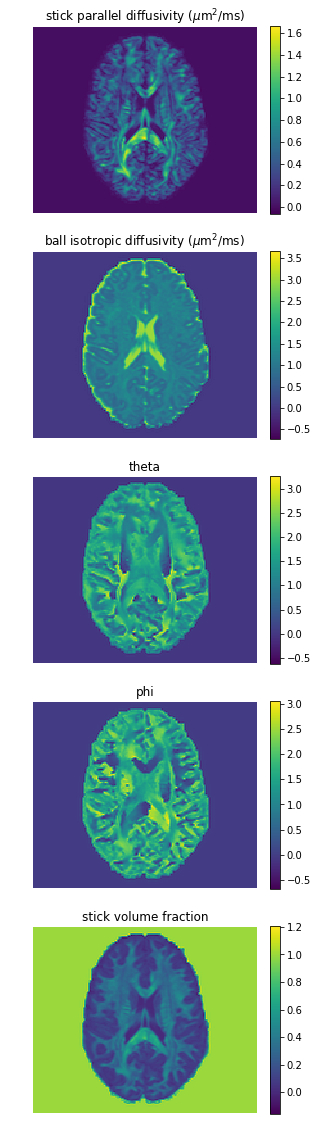

In [ ]:
fig, ax = plt.subplots(5, 1, figsize=(5,20))

zslice = 70

plt0 = ax[0].imshow(D_par_map[:,:,zslice])
plt.colorbar(plt0,ax=ax[0])
ax[0].xaxis.set_ticklabels([]) 
ax[0].set_title('stick parallel diffusivity ($\mu$m$^2$/ms)')
ax[0].axis('off')

plt0 = ax[1].imshow(D_iso_map[:,:,zslice])
plt.colorbar(plt0,ax=ax[1])
ax[1].set_title('ball isotropic diffusivity ($\mu$m$^2$/ms)')
ax[1].axis('off')

plt0 = ax[2].imshow(theta_map[:,:,zslice])
plt.colorbar(plt0,ax=ax[2])
ax[2].set_title('theta')
ax[2].axis('off')

plt0 = ax[3].imshow(phi_map[:,:,zslice])
plt.colorbar(plt0,ax=ax[3])
ax[3].set_title('phi')
ax[3].axis('off')

plt0 = ax[4].imshow(1-Fp_map[:,:,zslice])
plt.colorbar(plt0,ax=ax[4])
ax[4].set_title('stick volume fraction')
ax[4].axis('off')


In [ ]:
np.shape(mu_cart_map)

(145, 174, 145, 3)

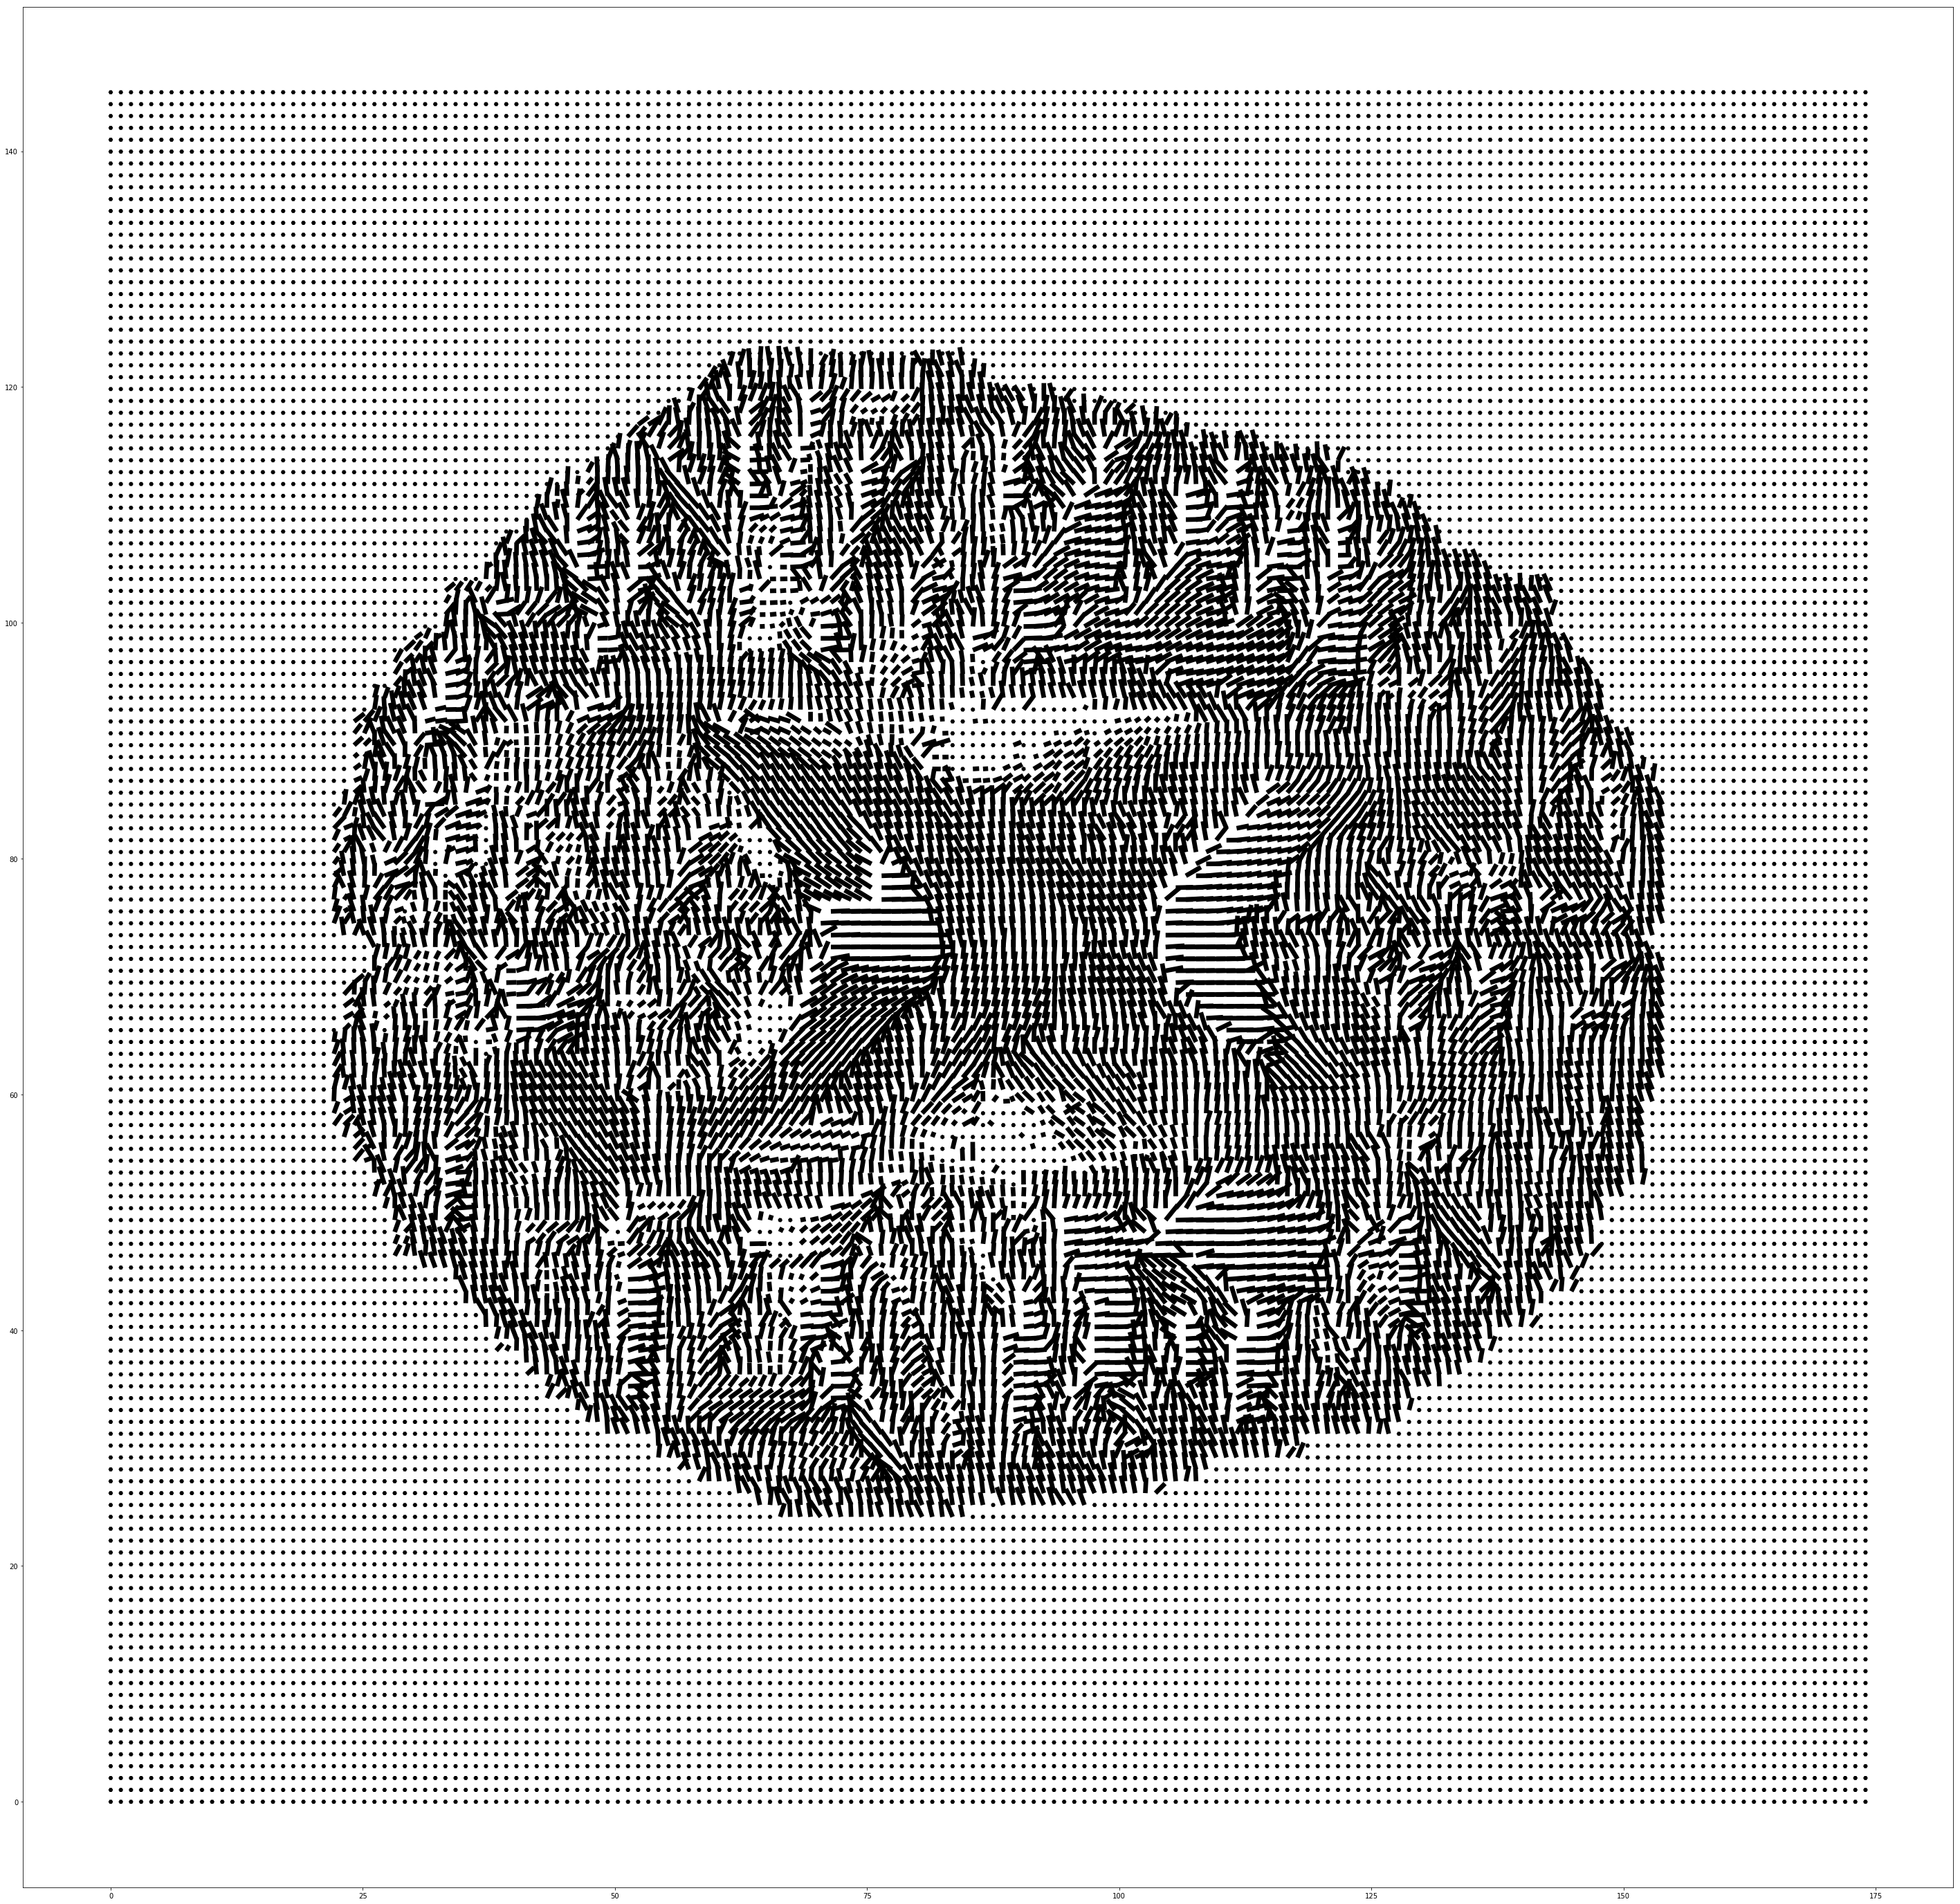

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(50,50))

x,y = np.meshgrid(np.linspace(0,np.shape(mu_cart_map)[1],np.shape(mu_cart_map)[1]), np.linspace(0,np.shape(mu_cart_map)[0],np.shape(mu_cart_map)[0]))

u = mu_cart_map[:,:,zslice,0]
v = mu_cart_map[:,:,zslice,1]

plt.quiver(x,y,u,v, headlength=0, headaxislength=0)
plt.show()
